In [3]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

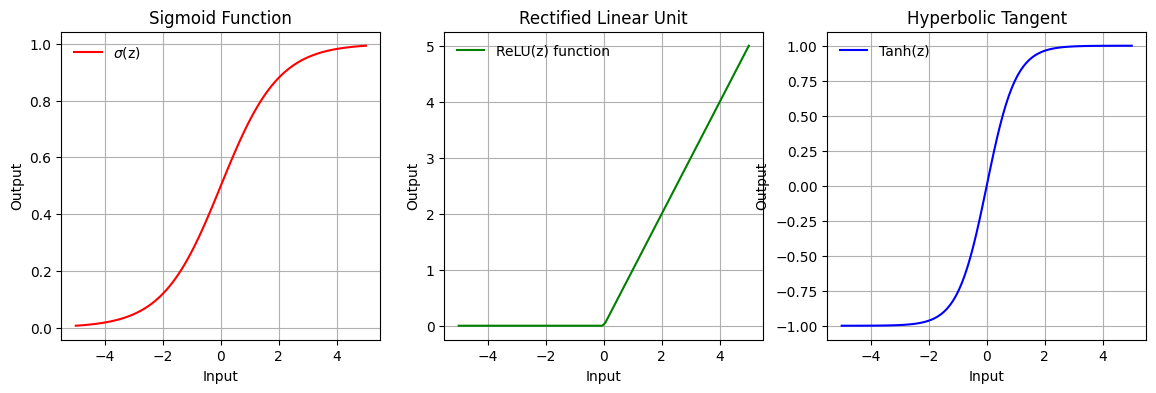

In [6]:
fig,axs = plt.subplots(1,3,figsize=(14,4))
sig = lambda z: 1/(1+np.exp(-z))
z = np.linspace(-5,5,100)
axs[0].plot(z,sig(z),label = r'$\sigma$(z)', color='r')
axs[0].set_title('Sigmoid Function')
axs[1].plot(z,torch.relu(torch.Tensor(z)),label = 'ReLU(z) function',color='g')
axs[1].set_title(r'Rectified Linear Unit')
axs[2].plot(z,np.tanh(z), label='Tanh(z)', color='b')
axs[2].set_title(r'Hyperbolic Tangent')
for ax in axs:
    ax.grid()
    ax.set_xlabel('Input')
    ax.set_ylabel('Output')
    ax.legend(frameon=False)

In [63]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import Module
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Dataset definition
class CSVDataset(Dataset):
    def __init__(self, path):
        # Load the CSV file as a DataFrame
        df = pd.read_csv(path)
        # Separate inputs and outputs
        self.X = df.iloc[:, :2].values  # First 2 columns are inputs (phi, epsilon)
        self.y = df.iloc[:, 2:].values  # Remaining columns are targets (coefficients)
        # Ensure input data is floats
        self.X = self.X.astype('float32')
        self.y = self.y.astype('float32')  # Ensure targets are floats

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    def get_splits(self, n_test=0):
        # Calculate sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # Split the dataset
        return random_split(self, [train_size, test_size])

# MLP model definition
class MLP(Module):
    def __init__(self, n_inputs, n_outputs):
        super(MLP, self).__init__()
        self.hidden1 = torch.nn.Linear(n_inputs, 40)
        torch.nn.init.kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = torch.nn.ReLU()
        self.hidden2 = torch.nn.Linear(40, 40)
        torch.nn.init.kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = torch.nn.ReLU()
        self.hidden3 = torch.nn.Linear(40, n_outputs)
        torch.nn.init.xavier_uniform_(self.hidden3.weight)
        self.act3 = torch.nn.Identity()
        # self.hidden4 = torch.nn.Linear(80, n_outputs)
        # torch.nn.init.xavier_uniform_(self.hidden4.weight)
        # self.act4 = torch.nn.Identity()

    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        # X = self.hidden4(X)
        # X = self.act4(X)
        return X

# Prepare the dataset
def prepare_data(path,batch_size):
    dataset = CSVDataset(path)
    train, test = dataset.get_splits()
    train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test, batch_size=32, shuffle=False)
    return train_dl, test_dl, dataset


# train the model
def train_model(train_dl, model,epochs=1000,lr=0.001):
    # define the optimization
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.7)
    losses = []  # to store loss values

    # enumerate epochs
    for epoch in range(epochs):
        epoch_loss = 0.0
        # enumerate mini batches
        for inputs, targets in train_dl:
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # accumulate the loss for this batch
            epoch_loss += loss.item()
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

        # average loss for the epoch
        epoch_loss /= len(train_dl)
        losses.append(epoch_loss)
        if epoch%100 == 0:
            print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')  # Optional: Print loss per epoch

    # plot the training loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(losses) + 1), losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    return losses

# Evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for inputs, targets in test_dl:
        yhat = model(inputs).detach().numpy()
        actual = targets.numpy()
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    mse = mean_squared_error(actuals, predictions)
    return mse

# Make a single prediction
def predict(row, model):
    row = torch.Tensor([row])
    yhat = model(row).detach().numpy()
    return yhat


In [62]:
class SequentialDataset(Dataset):
    def __init__(self, path, sequence_length=21):
        df = pd.read_csv(path)
        self.sequence_length = sequence_length
        self.X = df.iloc[:, :2].values  # Inputs (phi, epsilon)
        self.y = df.iloc[:, 2:].values  # Outputs (coefficients)

        # Convert to float32
        self.X = self.X.astype('float32')
        self.y = self.y.astype('float32')

        # Reshape data into sequences
        self.n_samples = len(self.X) // sequence_length
        self.X = self.X[:self.n_samples * sequence_length].reshape(self.n_samples, sequence_length, -1)
        self.y = self.y[:self.n_samples * sequence_length].reshape(self.n_samples, sequence_length, -1)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class RNN(Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3):
        super(RNN, self).__init__()
        self.rnn = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, X):
        # RNN forward pass
        out, _ = self.rnn(X)
        # Apply fully connected layer to each time step's output
        out = self.fc(out)  # Shape: (batch_size, seq_length, output_size)
        return out

def train_model_rnn(train_dl, model):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    losses = []

    for epoch in range(2000):
        epoch_loss = 0.0
        for inputs, targets in train_dl:
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss = criterion(outputs, targets)
            epoch_loss += loss.item()
            # Backward pass
            loss.backward()
            optimizer.step()

        epoch_loss /= len(train_dl)
        losses.append(epoch_loss)
        if epoch %100 == 0:
            print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

    return losses


class DeepRNN(Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3):
        super(DeepRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Recurrent layers
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layers after RNN
        self.fc1 = torch.nn.Linear(hidden_size, 100)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(100, 50)
        self.act2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(50, output_size)

    def forward(self, X):
        # RNN layer
        out, _ = self.rnn(X)  # Output shape: [batch, seq_length, hidden_size]
        out = out[:, -1, :]  # Take the output of the last time step

        # Fully connected layers
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        out = self.fc3(out)
        return out


In [21]:
sequence_length = 21
input_size = 2
example_input = torch.Tensor([[[0,0.1*i] for i in range(21)]]) 
example_input1 = torch.rand(1, sequence_length, input_size)  # Batch size 1, random example

# Get the model's output
model.eval()  # Set the model to evaluation mode (important for dropout, batch norm, etc.)
predicted_output = model(example_input)

# Convert to NumPy for inspection (optional)
predicted_output_np = predicted_output.detach().numpy()

In [63]:
# Prepare the dataset and DataLoader
path = 'output_parameters_allcoefs_noexp.csv'
sequence_length = 21
dataset = SequentialDataset(path, sequence_length)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

train_dl = DataLoader(train_data, batch_size=16, shuffle=True)
test_dl = DataLoader(test_data, batch_size=16, shuffle=False)

# Model initialization
input_size = 2  # (phi, epsilon)
hidden_size = 50
output_size = 18  # Number of coefficients
num_layers = 5
model = RNN(input_size, hidden_size, output_size, num_layers)

# Train the model
losses = train_model_rnn(train_dl, model)


Epoch 1, Loss: 0.9821
Epoch 101, Loss: 0.6197
Epoch 201, Loss: 0.1734
Epoch 301, Loss: 0.1423
Epoch 401, Loss: 0.1249
Epoch 501, Loss: 0.1123
Epoch 601, Loss: 0.1025
Epoch 701, Loss: 0.0947
Epoch 801, Loss: 0.0878
Epoch 901, Loss: 0.0812
Epoch 1001, Loss: 0.0757
Epoch 1101, Loss: 0.0716
Epoch 1201, Loss: 0.0689
Epoch 1301, Loss: 0.0671
Epoch 1401, Loss: 0.0659
Epoch 1501, Loss: 0.0652
Epoch 1601, Loss: 0.0646
Epoch 1701, Loss: 0.0642
Epoch 1801, Loss: 0.0640
Epoch 1901, Loss: 0.0638


Epoch 1, Loss: 1.9267
Epoch 101, Loss: 0.1157
Epoch 201, Loss: 0.0682
Epoch 301, Loss: 0.0706
Epoch 401, Loss: 0.0724
Epoch 501, Loss: 0.0803
Epoch 601, Loss: 0.0678
Epoch 701, Loss: 0.0659
Epoch 801, Loss: 0.0602
Epoch 901, Loss: 0.0614
Epoch 1001, Loss: 0.0662
Epoch 1101, Loss: 0.0536
Epoch 1201, Loss: 0.0559
Epoch 1301, Loss: 0.0510
Epoch 1401, Loss: 0.0595
Epoch 1501, Loss: 0.0504
Epoch 1601, Loss: 0.0478
Epoch 1701, Loss: 0.0599
Epoch 1801, Loss: 0.0557
Epoch 1901, Loss: 0.0604
Epoch 2001, Loss: 0.0513
Epoch 2101, Loss: 0.0458
Epoch 2201, Loss: 0.0474
Epoch 2301, Loss: 0.0465
Epoch 2401, Loss: 0.0460
Epoch 2501, Loss: 0.0416
Epoch 2601, Loss: 0.0494
Epoch 2701, Loss: 0.0439
Epoch 2801, Loss: 0.0462
Epoch 2901, Loss: 0.0486
Epoch 3001, Loss: 0.0432
Epoch 3101, Loss: 0.0453
Epoch 3201, Loss: 0.0419
Epoch 3301, Loss: 0.0371
Epoch 3401, Loss: 0.0428
Epoch 3501, Loss: 0.0397
Epoch 3601, Loss: 0.0368
Epoch 3701, Loss: 0.0400
Epoch 3801, Loss: 0.0396
Epoch 3901, Loss: 0.0408
Epoch 4001, 

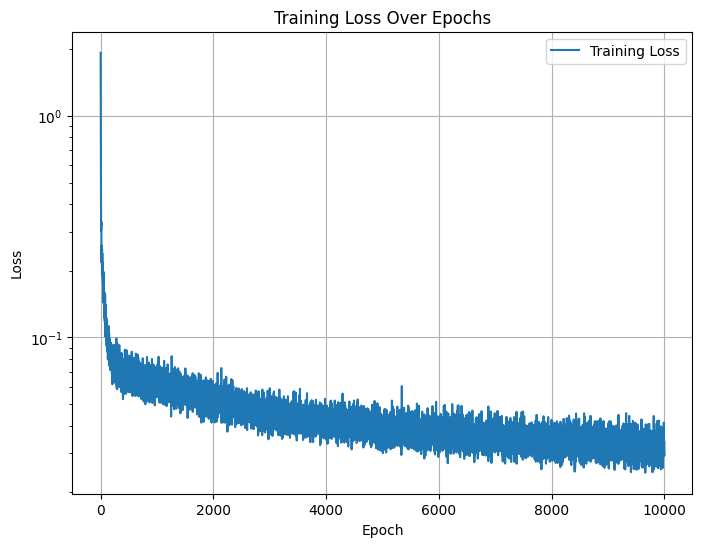

In [59]:
# Main execution
path = 'output_parameters29.11.csv'
train_dl, test_dl, dataset = prepare_data(path)
n_inputs = dataset.X.shape[1]
n_outputs = dataset.y.shape[1]

model = MLP(n_inputs, n_outputs)
losses = train_model(train_dl, model,10000)
# mse = evaluate_model(test_dl, model)
# print(f'MSE: {mse}')

Epoch 1, Loss: 0.0264
Epoch 101, Loss: 0.0263
Epoch 201, Loss: 0.0263
Epoch 301, Loss: 0.0262
Epoch 401, Loss: 0.0262
Epoch 501, Loss: 0.0261
Epoch 601, Loss: 0.0260
Epoch 701, Loss: 0.0261
Epoch 801, Loss: 0.0261
Epoch 901, Loss: 0.0258
Epoch 1001, Loss: 0.0258
Epoch 1101, Loss: 0.0257
Epoch 1201, Loss: 0.0256
Epoch 1301, Loss: 0.0256
Epoch 1401, Loss: 0.0257
Epoch 1501, Loss: 0.0255
Epoch 1601, Loss: 0.0255
Epoch 1701, Loss: 0.0255
Epoch 1801, Loss: 0.0255
Epoch 1901, Loss: 0.0254
Epoch 2001, Loss: 0.0253
Epoch 2101, Loss: 0.0253
Epoch 2201, Loss: 0.0252
Epoch 2301, Loss: 0.0252
Epoch 2401, Loss: 0.0251
Epoch 2501, Loss: 0.0250
Epoch 2601, Loss: 0.0250
Epoch 2701, Loss: 0.0249
Epoch 2801, Loss: 0.0249
Epoch 2901, Loss: 0.0248
Epoch 3001, Loss: 0.0249
Epoch 3101, Loss: 0.0247
Epoch 3201, Loss: 0.0249
Epoch 3301, Loss: 0.0248
Epoch 3401, Loss: 0.0247
Epoch 3501, Loss: 0.0245
Epoch 3601, Loss: 0.0246
Epoch 3701, Loss: 0.0244
Epoch 3801, Loss: 0.0245
Epoch 3901, Loss: 0.0243
Epoch 4001, 

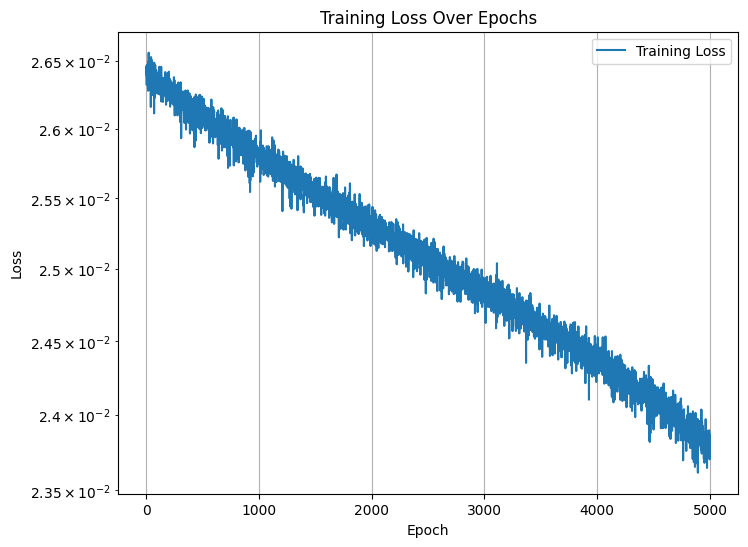

In [74]:
train_dl, test_dl, dataset = prepare_data(path,2)

losses = train_model(train_dl, model,epochs=5000,lr=0.001)

In [71]:
filename = r'PCYS_COEFS\Full\complete_coefs_bounded(.5,2.5)(L02.5,3)(L92.5,3).npz'
with np.load(f'{filename}') as data:
    all_coefs = data['all_coefs']  # Shape (18, 21, 10)
    all_exps = data['all_exps']    # Shape (21, 10)
    all_res = data['all_res']  

In [76]:
import os
save_directory = 'PCYS_COEFS\Full'
filename = 'ML_coefs_0279'

os.makedirs(save_directory, exist_ok=True)

file_path = os.path.join(save_directory, f'{filename}')

if not os.path.exists(f'{file_path}.npz'):
    np.savez(file_path,ML_coefs=ML_coefs,ML_exps=ML_exps)
else:
    print('Check if you are overwriting your files')

Check if you are overwriting your files


In [ ]:
sequence = torch.tensor([[0,0.1*i]for i in range(21)], dtype=torch.float32)
sequence = sequence.unsqueeze(0)  # Add batch dimension
model.eval()
output = model(sequence).detach().numpy()  # Shape: (1, seq_length, output_size)

plt.plot(range(21),output[0,:])


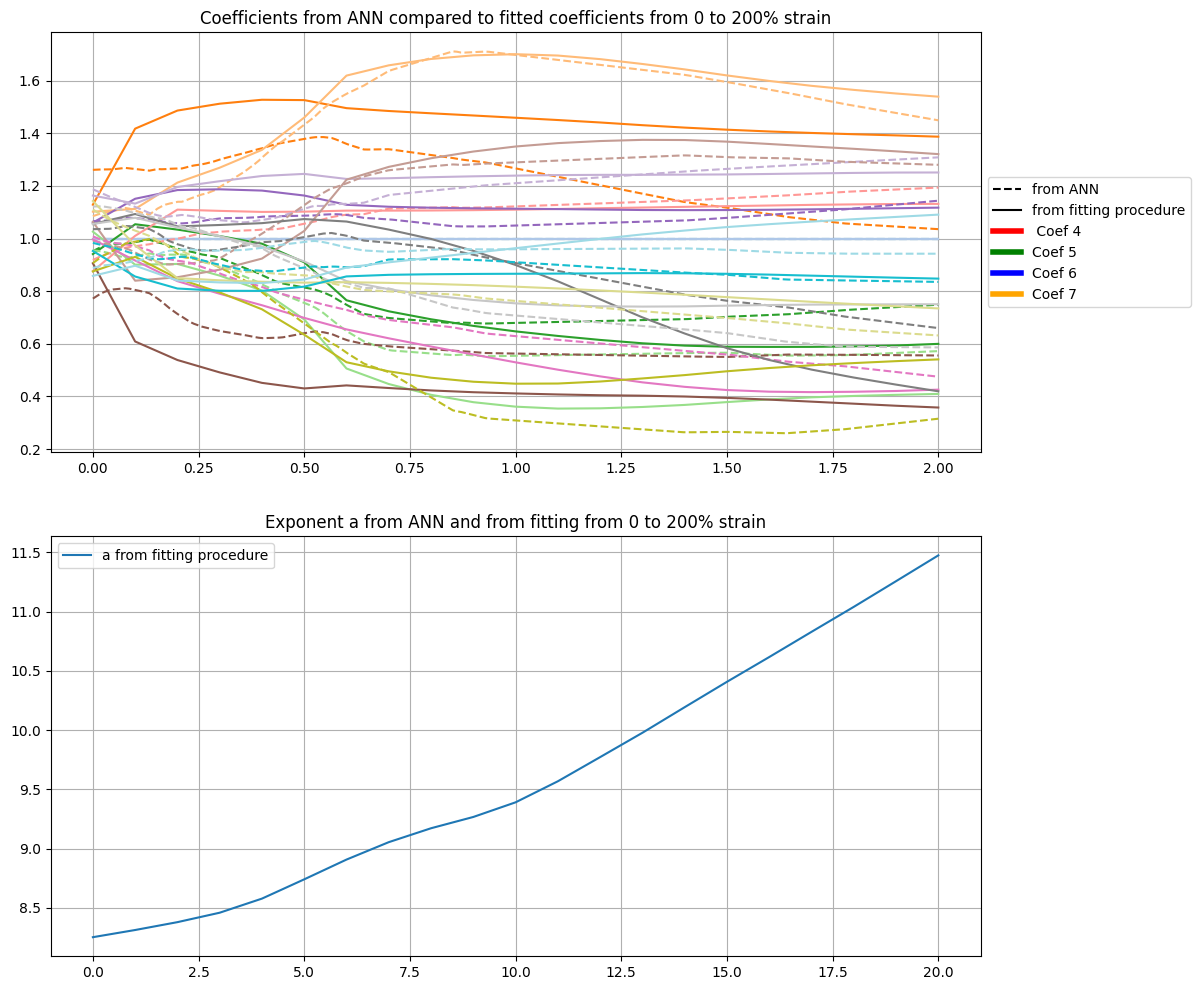

In [75]:
fig, (ax,ax2)  = plt.subplots(2,1,figsize=(12,12))
phi_values = np.linspace(0, np.pi/4, all_coefs.shape[2])  # Adjust angle range as needed
epsilon_values = np.linspace(0, 2, all_coefs.shape[1]*10)  # Adjust strain range as needed


ML_coefs = np.zeros((18,210,10))
ML_exps = np.zeros((21,10))
ML_coefs[:2,:] = 1
# Prepare the output data
inputs = np.zeros((2,210,10))
# Iterate through all combinations of epsilon and phi
for i, phi in enumerate(phi_values):  # Loop over strains (dimension 21)
    for j, epsilon in enumerate(epsilon_values):
            inputs[:,j,i] = [phi,epsilon]

for i in range(10):
     for j in range(210):
        # ML_coefs[:,j,i] = predict(inputs[:,j,i],model)[:,:-1]# with exponent
        # ML_exps[j,i] = predict(inputs[:,j,i],model)[:,-1]
        ML_coefs[2:,j,i] = predict(inputs[:,j,i],model)[:,:] #without exponent

colors = plt.cm.tab20(np.linspace(0, 1, all_coefs.shape[0]))
for i in range(18):
    ax.plot(np.linspace(0,2,21),all_coefs[i,:,2],ls='-',color=colors[i])
    ax.plot(epsilon_values,ML_coefs[i,:,2], ls ='--',color=colors[i])

legend_elements = [
    plt.Line2D([0], [0], color='k', linestyle='--', label=f'from ANN'),
    plt.Line2D([0], [0], color='k', linestyle='-', label=f'from fitting procedure'),
    plt.Line2D([0], [0], color='red', linewidth=4, label =' Coef 4'),
    plt.Line2D([0], [0], color='green', linewidth=4, label = 'Coef 5'),
    plt.Line2D([0], [0], color='blue', linewidth=4, label = 'Coef 6'),
    plt.Line2D([0], [0], color='orange', linewidth=4, label = 'Coef 7')
]
ax.set_title(r'Coefficients from ANN compared to fitted coefficients from 0 to 200% strain')
# ax2.plot(range(21),ML_exps[:,0],label = 'a from ANN' )
ax2.plot(range(21),all_exps[:,0], label = 'a from fitting procedure')
ax2.set_title(r'Exponent a from ANN and from fitting from 0 to 200% strain')

ax.grid()
ax2.grid()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5),handles=legend_elements)
ax2.legend()